In [189]:
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(False)
# debug._set_state(False)

from botorch.optim import optimize_acqf_discrete
from botorch.models.gp_regression import SingleTaskGP
import gpytorch

from gpytorch.constraints import Interval, GreaterThan
from botorch.models.transforms.outcome import Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

# script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
cwd = os.getcwd()
src_dir = "/".join(cwd.split("/")[:-1]) # src directory is two levels up
sys.path.append(src_dir)

from src.acquisition_functions.posterior_sampling import gen_posterior_sampling_batch
from src.acquisition_functions.bax_acquisition import BAXAcquisitionFunction
# from src.fit_model import fit_model
from src.bax.alg.levelset import LevelSetEstimator
from src.performance_metrics import F1Score
from src.experiment_manager import experiment_manager
# from src.fit_model import fit_model
from src.utils import (
    generate_initial_data,
    generate_random_points,
    get_obj_vals,
    seed_torch,
    optimize_acqf_and_get_suggested_batch,
    reshape_mesh, 
    get_mesh,
    get_function_samples,
)


In [247]:
def fit_model(inputs, outputs):
    if len(outputs.shape) == 1:
        outputs = outputs.view(torch.Size([outputs.shape[0], 1]))
    model = SingleTaskGP(
        train_X=inputs,
        train_Y=outputs,
        covar_module=None,
        outcome_transform=Standardize(m=outputs.shape[-1]),
    )
    # register noise contraints to the model to be less than 1e-5
    model.likelihood.noise_covar.register_constraint(
        "raw_noise", Interval(1e-8, 1e-4)
    )
    model.covar_module.base_kernel.register_constraint(
        "raw_lengthscale", Interval(1.5e-1, 2e-1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    return model
            

In [256]:
# means = torch.tensor([0.2, 0.5, 0.8])
# stds = torch.tensor([0.05, 0.05, 0.05])
# weights = torch.tensor([0.3, 0.4, 0.3])

seed_torch(0)

means = torch.tensor([0.3, 0.7])  # Means of the Gaussians
stds = torch.tensor([0.1, 0.15]) # Standard deviations of the Gaussians
weights = torch.tensor([0.5, 0.5]) # Weights of the Gaussians, making the left mode higher
def obj_func(x, means=means, stds=stds, weights=weights):
    if isinstance(x, np.ndarray):
        x = torch.tensor(x)
    gaussians = [w * torch.exp(-0.5 * ((x - m) / s) ** 2) / (s * torch.sqrt(torch.tensor(2 * torch.pi))) for m, s, w in zip(means, stds, weights)]
    return torch.sum(torch.stack(gaussians), dim=0)

# inputs = torch.linspace(0, 1, 8).reshape(-1, 1)
inputs = torch.tensor([
    [0.13],
    # [0.1],
    [0.2857],
    [0.47],
    [0.5714],
    [0.7143],
    [0.9],
    # [1.0000]
])
obj_vals = obj_func(inputs)

threshold = 1.1
kwargs = {}
model = fit_model(
    inputs,
    obj_vals,
)


x_set = np.linspace(0.1, 0.97, 1000).reshape(-1, 1)
algo_params = {
    "name" : "SimpleLevelSet",
    "threshold" : threshold,
    "x_set" : x_set,
    # "x_init" : x_init,
    "no_copy" : True,
}
algo = LevelSetEstimator(algo_params)

algo_gt = algo.get_copy()
exe_path_gt, output_gt = algo_gt.run_algorithm_on_f(obj_func)

batch_size = 1

In [257]:
# ps


algo_copy = algo.get_copy()
# x_next_ps = gen_posterior_sampling_batch(model, algo_copy, batch_size)
mc_values = {}
obj_func_sample = get_function_samples(model)
fsamp_vals = obj_func_sample(torch.from_numpy(x_set).unsqueeze(1)).detach().numpy() # (100, )

algo_samp = algo.get_copy()
x_output_ps = algo_samp.execute(obj_func_sample)
# get the max posterior variance of the output
var_out_post = model.posterior(torch.from_numpy(x_output_ps).unsqueeze(1)).variance.detach().numpy()
var_out_post = var_out_post.squeeze()
argmax_post = np.argmax(var_out_post)
x_max_post = x_output_ps[argmax_post].reshape(1, 1)

H_idx = np.where(fsamp_vals > threshold)[0]
H = x_set[H_idx].reshape(-1, 1)
H_values = fsamp_vals[H_idx]

L_idx = np.where(fsamp_vals <= threshold)[0]
L = x_set[L_idx].reshape(-1, 1)
L_values = fsamp_vals[L_idx]


In [265]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

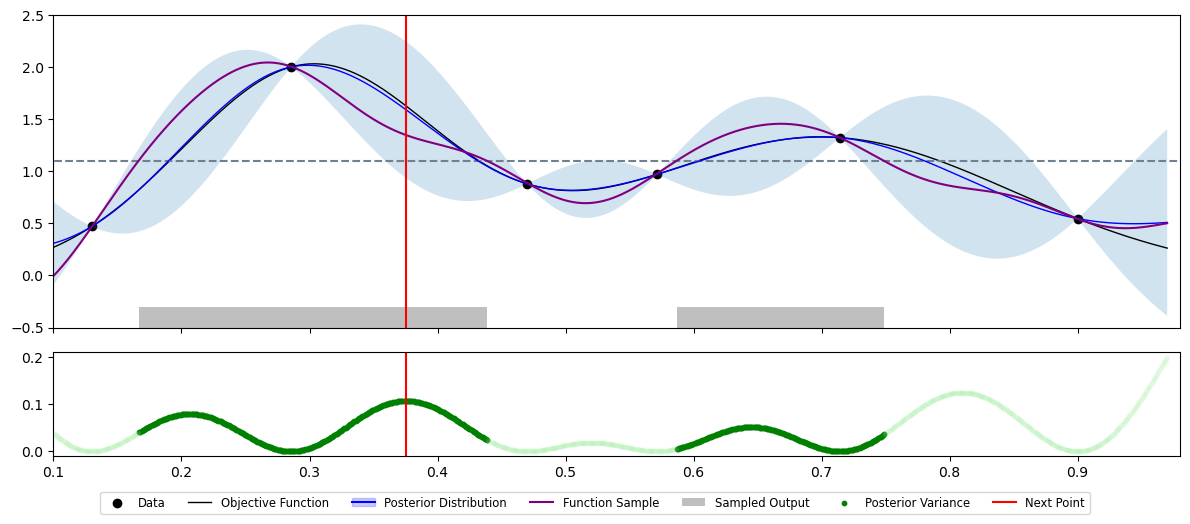

In [275]:
fig= plt.figure(figsize=(12, 5))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax = fig.add_subplot(gs[0])
ax.scatter(
    inputs, 
    obj_vals, 
    color="black", 
    label="Data"
)

y_true = obj_func(x_set)
ax.plot(
    x_set,
    y_true, 
    color="black",
    linewidth=1,
    label="Objective Function"
)
# ax.axhline(y=threshold, color="red", linestyle="--", label="Threshold")   
ax.plot(
    [0, 1], [threshold, threshold], color="slategrey", linestyle="--"
)



# ax.scatter(
#     H, 
#     H_values, 
#     color="#ff7f0e", 
#     marker=".",
#     s=20,
#     label="Superlevel Set"
# )

posterior = model.posterior(torch.from_numpy(x_set).unsqueeze(1))
mean, var = posterior.mean.detach().squeeze().numpy(), posterior.variance.detach().squeeze().numpy()
std = np.sqrt(var)
ax.plot(
    x_set, 
    mean, 
    linewidth=1,
    # alpha=0.5,
    color="blue",
    label="nolegend",
)
ax.fill_between(x_set.flatten(), mean - 2*std, mean + 2*std, alpha=0.2)

custom_handles = [
    (Line2D([0.1], [0.1], color='blue'), Patch(color='blue', alpha=0.2)),
]


fsamp_vals = obj_func_sample(torch.from_numpy(x_set).unsqueeze(1)).detach().numpy()
ax.plot(
    x_set, 
    fsamp_vals, 
    color="purple",
    label="Function Sample"
)

# feasible region
x1 = min(x_output_ps).item()

lh = x_output_ps[np.where(x_output_ps < 0.5)]
x2 = max(lh).item()
x3 = min(x_output_ps[np.where(x_output_ps > 0.5)]).item()
x4 = max(x_output_ps).item()

# plot the feasible region on the x-axis as a grey area
# ax.plot([x1, x2], [0, 0.5], color="grey", alpha=0.5)
# ax.plot([x3, x4], [0, 0.5], color="grey", alpha=0.5)
patch1 = patches.Rectangle((x1, -0.5), x2 - x1, 0.2, alpha=0.5, edgecolor='none', facecolor='grey', label="Sampled Output")
patch2 = patches.Rectangle((x3, -0.5), x4 - x3, 0.2, alpha=0.5, edgecolor='none', facecolor='grey')
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.set_xlim([0.1, 0.98])
ax.set_ylim([-0.5, 2.5])

ax2 = fig.add_subplot(gs[1], sharex=ax)
ax2.scatter(
    H,
    var[H_idx],
    color="green",
    marker="o",
    s=10,
    label="Posterior Variance"
)
ax2.scatter(
    L,
    var[L_idx],
    color="lightgreen",
    marker="o",
    s=10,
    alpha=0.1,
    # label="Posterior Variance"
)

plt.setp(ax.get_xticklabels(), visible=False)



# y_output = obj_func_sample(torch.from_numpy(x_output_ps).unsqueeze(1)).squeeze().numpy()
# ax.scatter(x_output_ps, y_output, color="red", label="Level Set Estimate")

# ax.plot(x_set, acq_vals, label="BAX Acquisition Function")

y_max_post = obj_func(x_max_post).squeeze().numpy()
# ax.scatter(
#     x_next_ps.squeeze().numpy(), 
#     y_next_ps, 
#     color="blue", 
#     marker="x",
#     s=100,
#     label="Selected Point"
# )
# draw a vertical line at the selected point
ax.axvline(x=x_max_post, color="red", linestyle="-", label ="Next Point")
ax2.axvline(x=x_max_post, color="red", linestyle="-")

# y_next_bax = obj_func_sample(x_next_bax.unsqueeze(1)).squeeze().numpy()
# ax.scatter(x_next_bax.squeeze().numpy(), y_next_bax, color="purple", label="BAX next")

handles, labels = [], []
next_h, next_l = None, None
for ax_ in [ax, ax2]:
    for h, l in zip(*ax_.get_legend_handles_labels()):
        if l == "nolegend":
            handles.extend(custom_handles)
            labels.extend(["Posterior Distribution"])
        elif l == "Next Point":
            next_h = h
            next_l = l
            continue
        else:
            handles.append(h)
            labels.append(l)
handles.append(next_h)
labels.append(next_l)
plt.tight_layout()

# Create a single legend at the bottom
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize="small", bbox_to_anchor=(0.5, -0.05))
plt.savefig(
    f"demo_levelset.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()


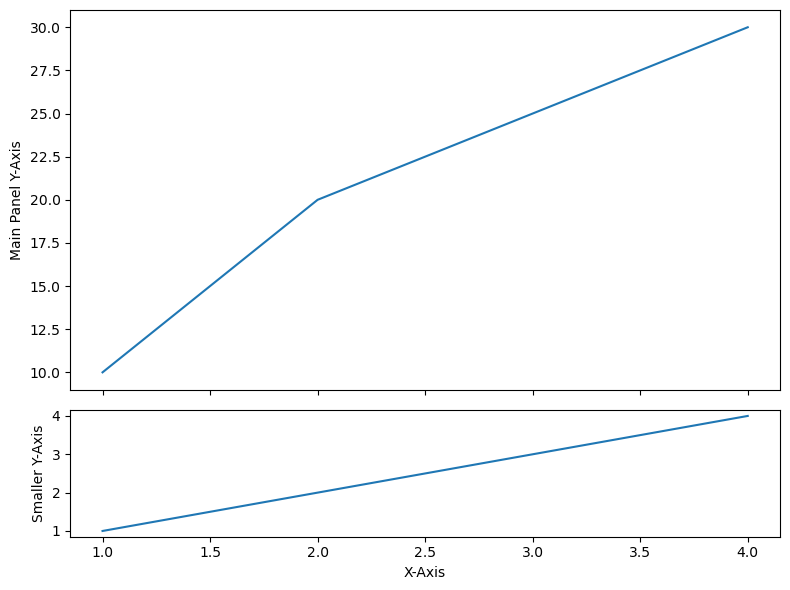

In [136]:


# Create a figure
fig = plt.figure(figsize=(8, 6))

# Define the GridSpec
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Create the first (main) panel
ax1 = fig.add_subplot(gs[0])
ax1.plot([1, 2, 3, 4], [10, 20, 25, 30])
ax1.set_ylabel('Main Panel Y-Axis')

# Create the second panel (smaller, on the bottom)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot([1, 2, 3, 4], [1, 2, 3, 4])
ax2.set_ylabel('Smaller Y-Axis')
ax2.set_xlabel('X-Axis')

# Remove x-tick labels from the first panel to avoid overlap
plt.setp(ax1.get_xticklabels(), visible=False)

# Adjust layout to prevent overlap
fig.tight_layout()

plt.show()

In [95]:
x1.item()

0.15015015015015015

In [31]:
# bax

acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
acq_func.initialize()
acq_vals = acq_func(torch.from_numpy(x_set).unsqueeze(1)).detach().numpy()
x_next_bax, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_set), max_batch_size=100)
            

In [ ]:
policies = ["ps", "bax"]
x_gp = {
    "ps" : inputs,
    "bax": inputs,
}
y_gp = {
    "ps" : obj_vals,
    "bax": obj_vals,
}
models = {
    "ps": deepcopy(model),
    "bax": deepcopy(model),
}

performance, output = evaluate_performance(model, algo.get_copy(), output_gt, **kwargs)
performances = {
    "ps": [performance],
    "bax": [performance],
}
_, output_mf = algo.run_algorithm_on_f(lambda x: model.posterior(x).mean)
outputs = {
    "ps": np.array(output_mf.x),
    "bax": np.array(output_mf.x)
}


In [ ]:
policies = ["ps", "bax"]
n_samp = 30
iter_mcvals = {}
acq_vals = []

for t in range(max_iter):
    for policy in policies:
        algo_samp = algo.get_copy()
        mc_values = {}
        for x in x_np:
            mc_values[tuple(x)] = 0
        for n in range(n_samp):
            obj_func_sample = get_function_samples(models[policy])
            x_output = algo_samp.execute(obj_func_sample)
            mc_vals = iter_mcvals.get(t, mc_values)
            for x in x_output:
                mc_vals[tuple(x)] += 1
        iter_mcvals[t] = mc_vals

        algo_copy = algo.get_copy()
        if policy == "ps":
            x_next = gen_posterior_sampling_batch(models[policy], algo_copy, batch_size)
        elif policy == "bax":
            acq_func = BAXAcquisitionFunction(
                model=model, 
                algo=algo_copy,
                **kwargs, 
            )
            acq_func.initialize()
            acq_vals.append(acq_func(torch.from_numpy(x_np).unsqueeze(1)).detach().numpy())
            x_next, _ = optimize_acqf_discrete(acq_function=acq_func, q=batch_size, choices=torch.from_numpy(x_np), max_batch_size=100)
            
        y_next = obj_func(x_next)
        x_gp[policy] = torch.cat([x_gp[policy], x_next], dim=0)
        y_gp[policy] = torch.cat([y_gp[policy], y_next], dim=0)
        models[policy] = fit_model(
            x_gp[policy], 
            y_gp[policy], 
            model_type="gp", 
            **kwargs
        )
        performance, output = evaluate_performance(models[policy], algo.get_copy(), output_gt, **kwargs)
        performances[policy].append(performance)
        outputs[policy] = np.concatenate((outputs[policy], np.array(output.x)), axis=0)

        print(f"Policy: {policy}, Iter: {t}, Performance: {performances[policy][-1]} \n")

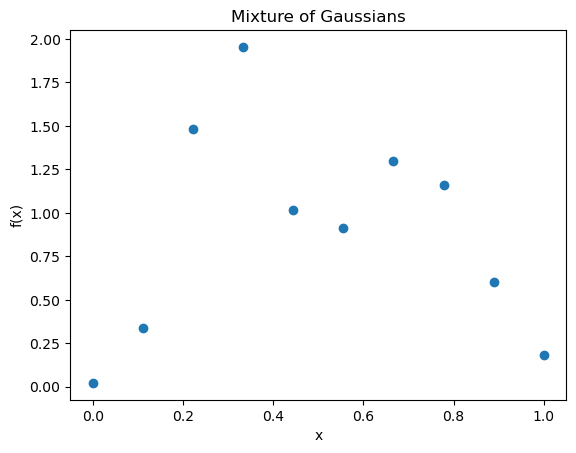

In [14]:
import torch

# Define the mixture of Gaussians


# Normalize the function so that it sums to 1 over the interval [0, 1]
# y = y / torch.trapz(y, x)

# Plot the function
plt.scatter(inputs.numpy(), obj_vals.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Mixture of Gaussians')
plt.show()


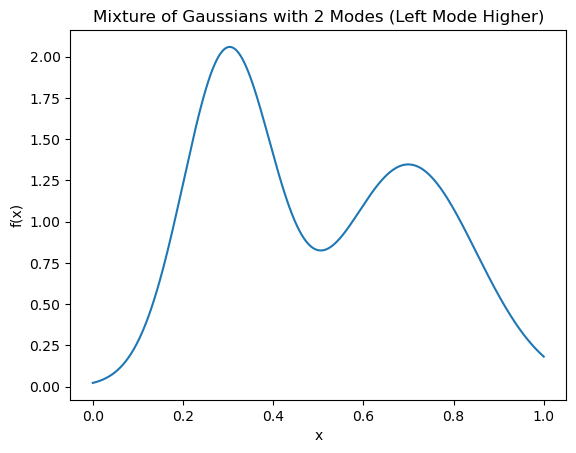

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the mixture of Gaussians
def mixture_of_gaussians(x, means, stds, weights):
    gaussians = [w * torch.exp(-0.5 * ((x - m) / s) ** 2) / (s * torch.sqrt(torch.tensor(2 * torch.pi))) for m, s, w in zip(means, stds, weights)]
    return torch.sum(torch.stack(gaussians), dim=0)

# Define the parameters for the mixture of Gaussians with 2 modes
means = torch.tensor([0.3, 0.7])  # Means of the Gaussians
stds = torch.tensor([0.1, 0.15]) # Standard deviations of the Gaussians
weights = torch.tensor([0.5, 0.5]) # Weights of the Gaussians, making the left mode higher

# Define the interval
x = torch.linspace(0, 1, 1000)

# Generate the function values
y = mixture_of_gaussians(x, means, stds, weights)

# Normalize the function so that it sums to 1 over the interval [0, 1]
y = y / torch.trapz(y, x)

# Plot the function
plt.plot(x.numpy(), y.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Mixture of Gaussians with 2 Modes (Left Mode Higher)')
plt.show()
